# Hands-on Python 3 (Part 2)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/Sistemi_a_combustione/blob/main/1.2-Hands-on_Python3_P2.ipynb)

Installing the libraries needed to approach the following engineering problems:

In [ ]:
%pip install numpy pandas scipy matplotlib

## Problem 1: Signal analysis

### Import libraries

In this code section, we import necessary libraries for numerical signal analysis.

In [98]:
import numpy as np  # import numpy
from matplotlib import pyplot as plt  # import the plotting library
from scipy.fft import fft, fftfreq  # import the FFT methods
from scipy.signal import butter, freqz, lfilter  # import methods for signal analysis

plt.style.use("default")

### Problem Statement

Let's begin by defining the problem:

In our hypothetical experiment, we have a Data Acquisition (DAQ) instrument with a sampling frequency of 50 kHz. We are conducting measurements on a rotating device with a speed of 3000 rotations per minute. To ensure accurate measurements, the time interval at which we sample should be a multiple of the device's rotational period.

The rotational period ($\tau$) is given by the reciprocal of the rotational frequency ($f$), and in this case:

$$ \tau = \dfrac{1}{f} = \dfrac{60}{3000} = 0.02\;\text{s} $$

Hence, we decide to sample the signal at a rate that is a multiple of this period, so we choose to sample it 10 times during each period.

In the following code, we will:

1. Define the frequencies of the events that we intend to measure and specify the high frequencies of the noise.
2. Create a time array ($t$) to represent the timing of the measurements.
3. Finally, we will compute the resulting measured signal by combining the desired signal and the noise.

In [151]:
# [Hz] Sampling frequency
SAMPLE_FREQ = 50e3  # [Hz]
# [Hz] Signal frequencies
WAVE_FREQ_1 = 5e2  # [Hz] main event
WAVE_FREQ_2 = 8.8e2  # [Hz] secondary event
WAVE_FREQ_3 = 1.1e3  # [Hz] secondary event
# [Hz] Noise frequencies
NOISE_FREQ_1 = 7e3  # [Hz]
NOISE_FREQ_2 = 12e3  # [Hz]
NOISE_FREQ_3 = 15e3  # [Hz]
NOISE_FREQ_4 = 23.5e3  # [Hz]


# Create signals (wave and noise)
t = np.arange(0, 10.0 / WAVE_FREQ_1, 1 / SAMPLE_FREQ)  # [s] sampling interval
wave = np.sum(
    [
        3.3 * np.sin(2 * np.pi * WAVE_FREQ_1 * t),  # wave defined as A*sin(2*pi*f*t)
        1.8 * np.sin(2 * np.pi * WAVE_FREQ_2 * t),
        1.2 * np.sin(2 * np.pi * WAVE_FREQ_3 * t),
    ],
    axis=0,
)
noise = np.sum(
    [
        0.7 * np.sin(2 * np.pi * NOISE_FREQ_1 * t),
        0.5 * np.sin(2 * np.pi * NOISE_FREQ_2 * t),
        0.8 * np.sin(2 * np.pi * NOISE_FREQ_3 * t),
        0.5 * np.sin(2 * np.pi * NOISE_FREQ_4 * t),
    ],
    axis=0,
)

# Combine wave and noise to create the "measured" signal
signal = wave + noise

### Plotting

In this code block, we are visualizing the problem using the `matplotlib` plot library to create a graphical representation of the signal and noise components. Here's a step-by-step explanation:

1. We define a `figure` object named `fig` with `plt.figure`. This object serves as the canvas on which our plot will be displayed.

2. The `figsize=(7, 3.5)` argument sets the dimensions of the plot. In this case, it creates a figure that is 7 inches wide and 3.5 inches tall. This specification controls the aspect ratio of the plot.

3. We use the `plt.style.context("seaborn-v0_8-paper")` context manager to set the plotting style to "seaborn-v0_8-paper." This style provides a particular appearance and formatting for the plot, enhancing its readability and aesthetics.

4. Within the context of the figure, we add a subplot with `ax = fig.add_subplot(111)`. The `add_subplot` function creates a subplot within the figure. The `111` argument means that this is a single subplot (1 row, 1 column), and it is the first subplot.

5. We create multiple line plots on the subplot using the `ax.plot()` function. The `t` array on the x-axis represents time, while the `signal`, `noise`, and `wave` arrays on the y-axis represent the signal with noise, noise alone, and the pure signal, respectively. Various parameters are used to customize the plot:
   - `alpha` specifies the opacity (transparency) of the lines, making the signal with noise more prominent (alpha=0.75) and the noise less prominent (alpha=0.5).
   - `label` assigns labels to each line for creating a legend.
   - `color` sets the color of the pure signal to black ('k').

6. We add a legend to the plot using `ax.legend()`. The legend helps identify and differentiate the plotted lines by associating them with their respective labels.

7. The x-axis label is set to "Time [s]" with `ax.set_xlabel("Time [s]")`, and the y-axis label is set to "Amplitude [-]" with `ax.set_ylabel("Amplitude [-]")`. These labels provide context and scale for interpreting the plot.

8. Finally, `plt.show()` is used to display the plot on the screen or in the Jupyter Notebook.

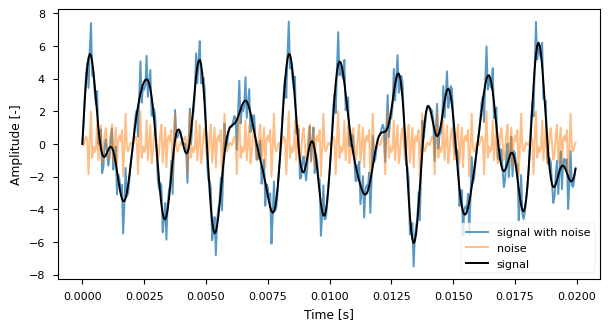

In [152]:
fig = plt.figure(figsize=(7, 3.5))

with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax.plot(t, signal, alpha=0.75, label="signal with noise")
    ax.plot(t, noise, alpha=0.5, label="noise")
    ax.plot(t, wave, label="signal", color="k")
    ax.legend()
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude [-]")
plt.show()

### Spectral analysis

Now, we analyze the signal in the frequency domain. When dealing with periodic functions, we utilize the mathematical tool known as the [Fourier Transform (FT)](https://en.wikipedia.org/wiki/Fourier_transform). It allows us to transition from the time domain to the frequency domain (or, in the case of spatial periodicity, the reciprocal space). This transformation is defined by the following equations:

- Forward Transform:
  $$ F(\omega) = \int_{-\infty}^{\infty} f(t) \cdot e^{-j 2\pi \omega t} \, dt $$

- Inverse Transform:
  $$ f(t) = \int_{-\infty}^{\infty} F(\omega) \cdot e^{j 2\pi \omega t} \, d\omega $$

Numerically, this transformation can be performed using the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). In essence, it approximates the integral with a sum, truncated to sufficiently high frequencies. The formula for the FFT is given by:

$$ F_k = \sum_{m=0}^{n-1} f_m \cdot e^{-j2\pi k m/n} \quad \text{for } k = 0, \ldots, n-1 $$

This essential tool is readily implemented in the `scipy.fft` library.

To remove noise from our signal, we employ a low-pass filter ($LP(\omega)$) designed using the [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) design method. In filter design, we specify critical parameters, including the filter order and the cutoff frequency ($f_{c}$). 

The cutoff frequency is a crucial parameter that defines the point at which the filter attenuates or reduces the amplitude of higher-frequency components in the signal. Specifically, it is the frequency at which the filter's response is -3 dB relative to its maximum amplitude. 

To ensure proper normalization and accurate filtering, we also calculate the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) ($f_{\text{Nyq}}$). The Nyquist frequency is equal to half of the sampling frequency ($f_{\text{sample}}$). It plays a fundamental role in signal processing, as it represents the maximum frequency that can be accurately represented or measured in the discrete time domain. 

In our case, $f_{\text{sample}}$ represents the sampling frequency of our signal, which is 50 kHz. Thus, by setting the cutoff frequency and understanding the Nyquist frequency, we ensure that our filtering process operates effectively and aligns with the capabilities of our sampling system.

Subsequently, we apply this filter to the original signal in the time domain to obtain the filtered signal. This process is mathematically represented as follows:

- Time Domain:
  $ f_{\text{filtered}}(t) = LP(\omega) * f(t) = \int_{-\infty}^{\infty} LP(\tau) \cdot f(t-\tau) \, d\tau $

- Frequency Domain:
  $ F_{\text{filtered}}(\omega) = LP(\omega) * F(\omega) = LP(\omega) \cdot F(\omega) $

In other words, in the time domain, the filtered signal is obtained by convolving the input signal with the filter's impulse response.

Finally, the FFT of the filtered signal is computed to analyze the frequency components of the filtered signal. This process enables us to understand the spectral content of the signal after applying the low-pass filter.


In [153]:
signal_fft = fft(signal)
freq_fft = fftfreq(len(signal), 1.0 / SAMPLE_FREQ)

# Low-pass filter (numeric)
order = 10  # filter order
cutoff = (
    5e3  # cutoff frequency (i.e. the frequency at which the signal is reduced by 3 dB)
)
nyq = 0.5 * SAMPLE_FREQ  # Nyquist frequency
b, a = butter(order, cutoff / nyq, btype="low", analog=False)
# apply the filter
signal_filtred = lfilter(b, a, signal)  # time space
signal_filtred_fft = fft(signal_filtred)  # frequency space

As before we plot the result to visualize the protocol and its result.

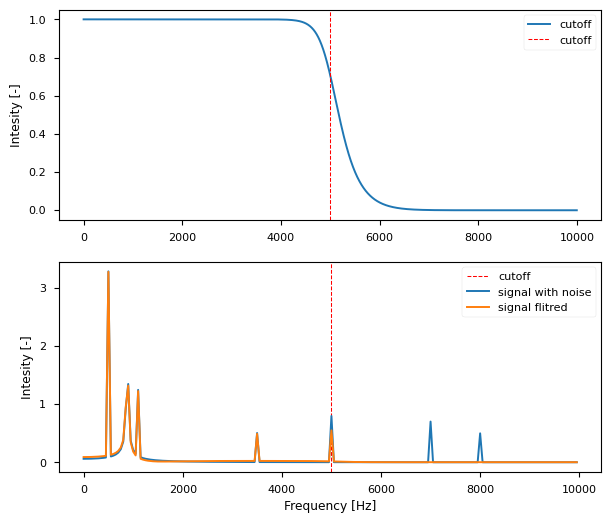

In [154]:
fig = plt.figure(figsize=(7, 6))

# data for the plot
filter_freq, filter_amplitude = freqz(b, a, worN=8000)
N = len(t)

with plt.style.context("seaborn-v0_8-paper"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.plot(
        0.5 * SAMPLE_FREQ * filter_freq / np.pi,
        np.abs(filter_amplitude),
        label="cutoff",
    )
    ax1.axvline(cutoff, color="r", ls="--", linewidth=0.75, label="cutoff")
    ax2.axvline(cutoff, color="r", ls="--", linewidth=0.75, label="cutoff")
    # plot half of the trransform which is symmetrical
    ax2.plot(
        freq_fft[: N // 2],
        2.0 / N * np.abs(signal_fft)[: N // 2],
        label="signal with noise",
    )
    ax2.plot(
        freq_fft[: N // 2],
        2.0 / N * np.abs(signal_filtred_fft)[: N // 2],
        label="signal flitred",
    )
    ax2.set_xlabel("Frequency [Hz]")
    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_ylabel("Intesity [-]")
plt.show()

Here, we visualize the result in the time domain to observe our measurements after applying the numerical filter through convolution. 

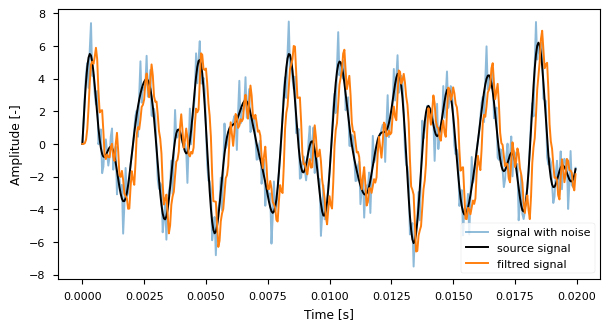

In [155]:
fig = plt.figure(figsize=(7, 3.5))

with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax.plot(t, signal, alpha=0.5, label="signal with noise")
    ax.plot(t, wave, label="source signal", color="k")
    ax.plot(t, signal_filtred, label="filtred signal")
    ax.legend()
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude [-]")
plt.show()

## Problem 2: Estimating π using Monte Carlo Simulation

In this second example, we will explore a classical problem in computational mathematics: estimating the value of $\pi$ using a [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method). 

The Monte Carlo method is a powerful technique for solving problems through random sampling, and it can be applied to various mathematical and scientific challenges.

### Problem Statement

We want to estimate the value of $\pi$, which is the fundamental, and well know, mathematical constant representing the ratio of a circle's circumference to its diameter. Mathematically, it's defined as:

$$ \pi = \frac{C}{d} $$

Where:
- $ \pi $ is the value we seek to estimate.
- $ C $ stands for the circumference of a circle.
- $ d $ represents the diameter of the same circle.

However, an interesting relationship comes into play: the area of a unit circle (a circle with a radius of $r = 1$) is equal to $\pi$. As a result, if we suppose a random event where we are dropping a coin onto a square tile with a side length of 1, which inscribes a quarter of a circle, the probability that the coin lands inside the circle is the ratio of the areas involved.

$$\rho = \frac{\text{Number of coins inside the circle}}{\text{Total number of coins}} = \frac{A_{\text{circle}}}{A_{\text{square}}} = \frac{\frac{\pi}{4}}{1} = \frac{\pi}{4} $$

This realization allows us to estimate the value of $\pi$ by understanding the probability of a coin falling inside the circle. Hence, the estimation of $\pi$ is calculated as:

$$ \pi = 4 \cdot \rho $$

The Monte Carlo method, in an exceedingly simplified form, is utilized for estimating the probability density function of an event. It does this by randomly sampling the state space of a system and implementing an acceptance criterion. In our case, the acceptance criterion is that a point (or coin) falls within the circle, which can be determined by checking if $x^2 + y^2 \le 1 $.

Please note how this problem encapsulates the beauty of Monte Carlo simulations in estimating "complex" mathematical constants by leveraging the principles of probability and geometry.

### Import libraries

In this code section, we import necessary libraries for numerical signal analysis.

In [ ]:
import numpy as np  # import numpy
from matplotlib import pyplot as plt  # import the plotting library

plt.style.use("default")

In [177]:
# Number of iterations
iterations = 300000

# Initialize variables to store convergence data
points_in = np.zeros(iterations, dtype="uint")
points_tot = np.zeros(iterations, dtype="uint")
i_in = np.zeros(iterations, dtype="bool")
x = np.zeros(iterations)
y = np.zeros(iterations)


for i in range(iterations):
    # Generate random points in the square
    x[i], y[i] = np.random.uniform(0, 1, size=2)

    # Calculate the distance from the origin for each point
    r = np.sqrt(x[i] ** 2 + y[i] ** 2)

    # Acceptance criteria: Check if points are inside the quarter circle
    if r <= 1.0:
        points_in[i] = points_in[i - 1] + 1
        i_in[i] = True
    else:
        points_in[i] = points_in[i - 1]
        i_in[i] = False
    points_tot[i] = points_tot[i - 1] + 1

# Calculate the estimated value of π
rho = points_in / points_tot  # probability
pi_estimate = 4 * rho

Let's visualize the simulation

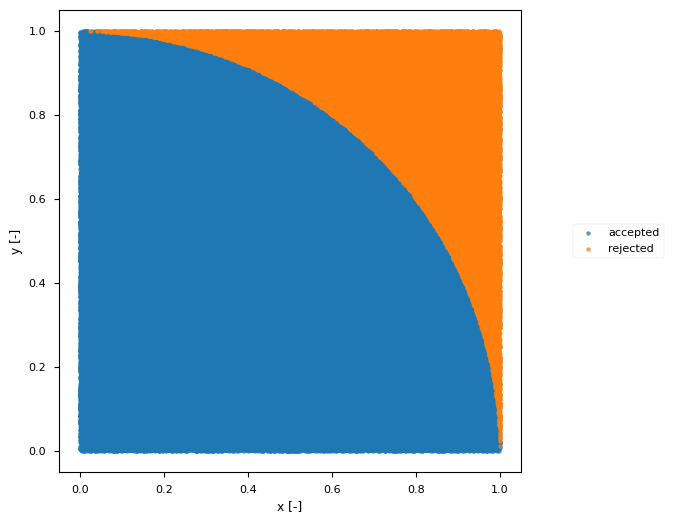

In [178]:
fig = plt.figure(figsize=(6, 6))

with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax.scatter(x[i_in], y[i_in], s=8, alpha=0.75, label="accepted")
    ax.scatter(
        x[np.logical_not(i_in)],
        y[np.logical_not(i_in)],
        s=8,
        alpha=0.75,
        label="rejected",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
    ax.set_aspect("equal")
    ax.set_xlabel("x [-]")
    ax.set_ylabel("y [-]")

How it converge?

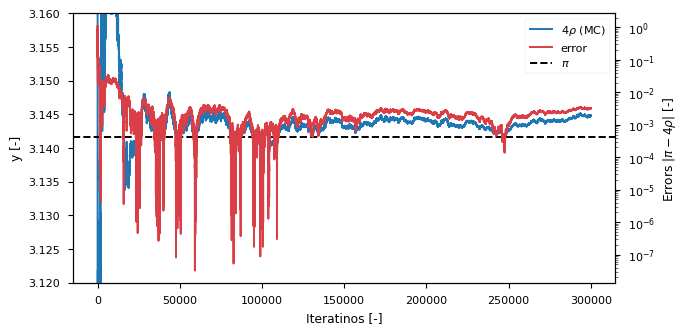

In [180]:
fig = plt.figure(figsize=(7, 3.5))

with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    p1 = ax.plot(pi_estimate)
    p2 = ax_twin.plot(np.abs(pi_estimate - np.pi), color="#da3e46")
    p3 = ax.axhline(np.pi, color="k", ls="--")
    ax.legend(p1 + p2 + [p3], [r"$4\rho$ (MC)", r"error", r"$\pi$"], loc="upper right")
    ax.set_xlabel("Iteratinos [-]")
    ax.set_ylabel("y [-]")
    ax.set_ylim([3.12, 3.16])
    ax_twin.set_ylabel(r"Errors $ | \pi-4\rho |$ [-]")
    ax_twin.set_yscale("log")

## Problem 3: Solving 1D Heat Diffusion 

In this example, we will explore the numerical solution of the one-dimensional heat diffusion equation using the explicit Euler method. 

### Problem Statement

Imagine placing two metal rods with different temperatures in contact. After they come into contact, heat diffuses from the hot rod to the cold one, and its evolution over time can be described by the [parabolic](https://en.wikipedia.org/wiki/Parabolic_partial_differential_equation) partial differential equation (PDE) known as the [*heat equation*](https://en.wikipedia.org/wiki/Heat_equation). Due to the symmetry of the problem, we can simplify the PDE from three dimensions to one dimension. Therefore, the 1D heat equation is given by:

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

Where:
- $u(x, t)$ is the temperature at position $x$ and time $t$.
- $\alpha$ is the thermal diffusivity of the material.

### Discretization

To numerically solve the heat diffusion equation, we discretize time into time steps ($\Delta t$) and space into grid points ($\Delta x$). This results in a grid of temperature values at various positions and times.

Let's represent the temperature at the $i$-th spatial grid point and the $n$-th time step as $u_i^n$. The heat diffusion equation can be discretized as follows:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = \alpha \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

This discretized equation allows us to update the temperature at each grid point in the next time step using the values at the current time step.

### Explicit Euler Method

The explicit [Euler method](https://en.wikipedia.org/wiki/Euler_method) is a straightforward yet effective way to solve time-dependent partial differential equations, such as the heat diffusion equation. It updates the temperature at each grid point using information from the previous time step and is derived from the first-order finite difference of the time derivative.

The update formula for the explicit Euler method is:

$$u_i^{n+1} = u_i^n + \alpha \frac{\Delta t}{\Delta x^2} (u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

By repeatedly applying this formula for all grid points, we can approximate the temperature distribution over time.

### Well-define problem

To ensure the uniqueness of the solution, we must apply boundary conditions (BC). Because it is a parabolic PDE we need one condition for the time domain and two for the space domain:

* Initial condition: $u(t=0) = u_0$
* Boundary conditions: $u(x=0) = T_{hot}, \, u(x=L) = T_{cold}$

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define parameters
alpha = 97e-6  # [m^2/s] Thermal diffusivity (aluminum)
L = 1.0  # [m] Length of the rod
T = 60.0  # [s] Total simulation time

# Discretization
Nx = 80  # Number of spatial grid points
dx = L / Nx
dt = 5e-3  # [s] Time step
Nt = int(T / dt)  # Number of time step

# Initialize temperature array
u = np.zeros(Nx + 1)

# Initial condition: temperature distribution at t=0
u[: Nx // 2] = 400  # [K] hot rod
u[Nx // 2 :] = 200  # [K] cold rod

# We initialize a vector for storing the profile and plots
u_t = np.zeros((4, Nx + 1))
t = np.zeros(4)

# Time-stepping with explicit Euler
n_save = 0
for n in range(Nt):
    if n % (Nt // 4) == 0:
        u_t[n_save, :] = u
        t[n_save] = dt * n
        n_save += 1
    for i in range(1, Nx):
        u[i] = u[i] + alpha * dt / dx**2 * (u[i + 1] - 2 * u[i] + u[i - 1])
# Plot the temperature evolution

Let's, as usual, plot the result

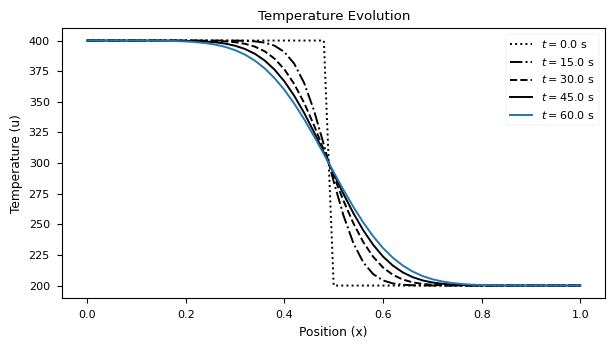

In [16]:
fig = plt.figure(figsize=(7, 3.5))
x = np.linspace(0, L, Nx + 1)
ls = [":", "-.", "--", "-"]
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    for i in range(4):
        ax.plot(x, u_t[i], ls=ls[i], color="k", label=f"$t=${t[i]:1.1f} s")
    ax.plot(x, u, label=f"$t=${dt*Nt:1.1f} s")
    ax.legend()
    ax.set_title("Temperature Evolution")
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Temperature (u)")
plt.show()

## Problem 4: Time integration of a dynamic system

In this example, we will explore the time evolution of a dynamic system, specifically a spring oscillation under the influence of a gravitational field.
We will formulate the equation of motion, split it into a system of first-order ordinary differential equations (ODEs) to solve in the phase space, and integrate it using the implicit Euler method. We will consider an ideal spring, so energy is conserved during the oscillation.

### Problem Statement

The equation of motion for a spring oscillation under the influence of gravity is a second-order ODE:

$$m \dfrac{d^2x}{dt^2} = -kx - mg$$

Where:
- $m$ is the mass of the object.
- $k$ is the spring constant.
- $x$ is the displacement from the equilibrium position.
- $g$ is the acceleration due to gravity.

To solve this equation, we'll first split it into a system of first-order ODEs in the phase space:

$$
\begin{cases}
    \dfrac{dx}{dt} = v \\
    \dfrac{dv}{dt} = -\frac{k}{m}x - g
\end{cases}
$$


We will then integrate this system using the implicit Euler method.

As before, Let's implement the explicit Euler method in Python to solve the system of ODEs and visualize the spring's oscillation.

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# System parameters
m = 1.0  # Mass
k = 1.0  # Spring constant
g = 9.81  # Acceleration due to gravity

# Initial conditions
x0 = 1.0  # Initial displacement
v0 = 0.0  # Initial velocity

# Time parameters
T = 2 * np.pi  # Total simulation time (3 periods)
dt = 0.02  # Time step

# Number of time steps
num_steps = int(T / dt)

# Initialize arrays to store results
time = np.zeros(num_steps)
displacement = np.zeros(num_steps)
velocity = np.zeros(num_steps)

# Set initial conditions for explicit Euler
displacement[0] = x0
velocity[0] = v0

# Integrate the system using explicit Euler
for i in range(1, num_steps):
    # Compute acceleration at the current position
    acceleration = -k / m * displacement[i - 1] - g

    # Update the velocity
    velocity[i] = velocity[i - 1] + acceleration * dt

    # Update the displacement
    displacement[i] = displacement[i - 1] + velocity[i - 1] * dt

    # Update time
    time[i] = time[i - 1] + dt

Let's plot the system evolution on the Phase Space

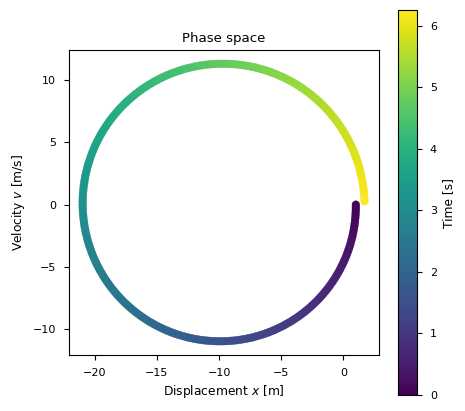

In [62]:
fig = plt.figure(figsize=(5, 5))
x = np.linspace(0, L, Nx + 1)
ls = [":", "-.", "--", "-"]
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    sp = ax.scatter(displacement, velocity, c=time)
    plt.colorbar(sp, label="Time [s]")
    ax.set_xlabel("Displacement $x$ [m]")
    ax.set_ylabel("Velocity $v$ [m/s]")
    ax.set_title("Phase space")
    ax.set_aspect("equal")
plt.show()

### Improve the Energy Conservation with Verlet Integration

Now, let's explore how to use the Verlet integration method to simulate the spring oscillation while conserving energy. The Verlet method is a symplectic numerical integration technique that can be particularly useful for dynamic systems with conserved energy, like ideal springs.

#### Verlet Integration Method

The Verlet method is based on the position and velocity Verlet algorithm, which provides a better conservation of energy compared to implicit methods like the Euler method. It updates the position and velocity of the system based on the following formulas:

- Update the position: $$x_{n+1} = x_n + v_n \Delta t + \frac{1}{2} a_n \Delta t^2$$
- Calculate the acceleration: $$a_{n+1} = -\frac{k}{m}x_{n+1} - g$$
- Update the velocity: $$v_{n+1} = v_n + \frac{1}{2}(a_n + a_{n+1})\Delta t$$

The Verlet method combines both position and velocity updates, resulting in more accurate and energy-conserving simulations.

#### Implementation in Python (Verlet Integration)

Let's implement the Verlet integration method in Python to simulate the spring oscillation. We will use the same parameters and initial conditions as in the previous example.


In [63]:
# Initialize arrays to store results
displacement_verlet = np.zeros(num_steps)
velocity_verlet = np.zeros(num_steps)

# Set initial conditions
displacement_verlet[0] = x0
velocity_verlet[0] = v0

# Integrate the system using Verlet integration
for i in range(1, num_steps):
    # Update the position
    displacement_verlet[i] = (
        displacement_verlet[i - 1]
        + velocity_verlet[i - 1] * dt
        + 0.5 * (-k / m * displacement_verlet[i - 1] - g) * dt**2
    )

    # Calculate the acceleration
    acceleration = -k / m * displacement_verlet[i]

    # Update the velocity
    velocity_verlet[i] = (
        velocity_verlet[i - 1]
        + 0.5 * (acceleration + (-k / m * displacement_verlet[i] - g)) * dt
    )

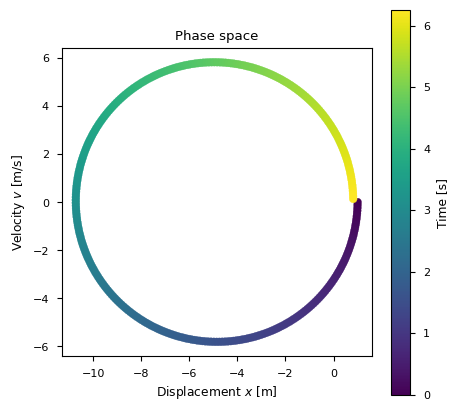

In [64]:
fig = plt.figure(figsize=(5, 5))
x = np.linspace(0, L, Nx + 1)
ls = [":", "-.", "--", "-"]
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    sp = ax.scatter(displacement_verlet, velocity_verlet, c=time)
    plt.colorbar(sp, label="Time [s]")
    ax.set_xlabel("Displacement $x$ [m]")
    ax.set_ylabel("Velocity $v$ [m/s]")
    ax.set_title("Phase space")
    ax.set_aspect("equal")
plt.show()

## Esercizio clustering fiore *Iris*

# Problem 5: Unsupervised Clustering for Iris Species Recognition

The exercise involves using an unsupervised clustering method to automatically recognize the species of *Iris* solely based on the lengths and widths of the petals and sepals.

To do this, we need to:

0. Install `scikit-learn`.
1. Download and import the dataset (`iris.csv`).
2. Take an initial look at the data and determine if any data cleaning is necessary.
3. Normalize the values (see [Normalization](https://en.wikipedia.org/wiki/Normalization_(statistics))).
4. Reduce the dimensionality using [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).
5. Use the unsupervised clustering method, *Gaussian Mixture* (see [Gaussian Mixture Models Explained](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)).

![The three different Iris species](https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/iris.png)

### 0. Install the Machine Learning library `scikit-learn`

In [ ]:
%pip install scikit-learn==1.0.2

### 1. Download the Database `iris.csv`

We will download the `iris.csv` database.

In [ ]:
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab1/iris.csv

### 1. Import the Database Using `pandas`

Let's import the database using the `read_csv` method from `pandas`.

<div class="alert alert-block alert-info">
<b>Note:</b> 

csv = Comma-Separated Values
<br>
It is a common file format for saving data, readable by both humans and machines.
</div>

In [ ]:
import numpy as np  # importo numpy
import pandas as pd  # importo pandas
from matplotlib import pyplot as plt  # importo la libreria per plottare

plt.style.use("default")

iris_data = pd.read_csv("iris.csv")
iris_data["species"] = iris_data["species"].astype("category")
iris_data

### 2. Take an Initial Look at the Data and Check for Cleaning Requirements

One of the first things to do is to perform a quick data analysis and visualization. A useful metric to examine is the correlation between the different data points.

In [ ]:
help(iris_data.corr)

In [ ]:
iris_corr = iris_data.corr(numeric_only=True)  # Pearson correlation coefficient
# vd. https://it.wikipedia.org/wiki/Indice_di_correlazione_di_Pearson
iris_corr.style.background_gradient(cmap="coolwarm")

In [ ]:
fig = plt.figure(figsize=(9, 6))

data_axis = ["petal_width", "petal_length"]  # prova a cambiarli

with plt.style.context("seaborn"):
    ax = fig.add_subplot(111)
    for label in iris_data["species"].unique():
        sub_set = iris_data.loc[
            iris_data["species"] == label
        ]  # plotto ogni specie con colori diversi
        ax.scatter(sub_set[data_axis[0]], sub_set[data_axis[1]], label=label)
    ax.legend()
    ax.set_xlabel(data_axis[0])
    ax.set_ylabel(data_axis[1])
plt.show()

### 3. Normalize the Values

There are various methodologies for normalization, with the main ones being:

| Method | Formula    |
| --- | --- |
| Standardization | $ \dfrac{X-\mu }{\sigma }$ |
| Student's t | $ \dfrac{\widehat{\beta }-\beta _{0}}{\text{s.e.} ({\widehat {\beta }})}$ |
| Min-max | $\dfrac{X - X_{\min }}{X_{\max }- X_{\min }}$ |

In [ ]:
from sklearn.preprocessing import StandardScaler

X_raw = iris_data.iloc[:, :-1].values.astype(float)  # separiamo i dati...
Y_raw = iris_data.iloc[:, -1].values.astype(str)  # ...dalle etichette

normalizer = StandardScaler()
X = normalizer.fit_transform(X_raw)

# se tutto e andato bene la media dovrebbe essere 0 e la deviazione standard 1
print("mean: ", X.mean(axis=0))
print("std: ", X.std(axis=0))

### 4. Reduce Dimensionality with Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that allows us to represent the data in a lower-dimensional space while retaining most of the variance. .

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)  # Prova a cambiare il numero di componenti (il massimo è 4)
X_pca = pca.fit_transform(X)

In [ ]:
fig = plt.figure(figsize=(12, 6))

data_axis = ["petal_width", "petal_length"]  # prova a cambiarli

with plt.style.context("seaborn"):
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for label in iris_data["species"].unique():
        indexs = np.where(Y_raw == label)[0]
        sub_set = iris_data.loc[
            iris_data["species"] == label
        ]  # plotto ogni specie con colori diversi
        ax1.scatter(sub_set[data_axis[0]], sub_set[data_axis[1]], label=label)
        ax2.scatter(X_pca[indexs, 0], X_pca[indexs, 1], label=label)
    ax1.legend()
    ax1.set_xlabel(data_axis[0])
    ax1.set_ylabel(data_axis[1])
    ax2.set_xlabel("1st component")
    ax2.set_ylabel("2nd component")
plt.show()

### 5. Use the Unsupervised Clustering Method `GaussianMixture`

In this step, we'll use the unsupervised clustering method `GaussianMixture`. This algorithm assumes that the data in each cluster follows a multidimensional Gaussian probability distribution. The algorithm takes the number of desired clusters, `n_components`, and estimates the parameters ($\mu$, $\sigma$) that maximize the [Maximum Likelihood Estimate (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

![EM Clustering](https://upload.wikimedia.org/wikipedia/commons/6/69/EM_Clustering_of_Old_Faithful_data.gif)

This visualization shows the Expectation-Maximization (EM) Clustering process, which is commonly used in Gaussian Mixture Models.

In [ ]:
from sklearn.mixture import GaussianMixture

cluster_model = GaussianMixture(
    n_components=3,  # Il numero di `Mixture` cioè di cluster da cercare
    covariance_type="full",  # Stima/calcolo della matrice di covarianza
)
# training
cluster_model.fit(X_pca)
Y_prediction = cluster_model.predict(X_pca)

#### Evaluate the Clustering Results

Let's evaluate the clustering results, initially qualitatively, by plotting the original clusters versus those predicted by the model.

In [ ]:
fig = plt.figure(figsize=(12, 6))

data_axis = ["petal_width", "petal_length"]  # prova a cambiarli

with plt.style.context("seaborn"):
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for label in iris_data["species"].unique():
        indexs = np.where(Y_raw == label)[0]
        sub_set = iris_data.loc[
            iris_data["species"] == label
        ]  # plotto ogni specie con colori diversi
        ax1.scatter(X_pca[indexs, 0], X_pca[indexs, 1], label=label)
    for clust_id in np.unique(Y_prediction):
        indexs = np.where(Y_prediction == clust_id)[0]
        ax2.scatter(X_pca[indexs, 0], X_pca[indexs, 1], label=f"cluster {clust_id}")
    for ax in [ax1, ax2]:
        ax.legend()
        ax.set_xlabel("1st component")
        ax.set_ylabel("2nd component")
plt.show()

#### Then Evaluate the Model Quantitatively

Next, we will evaluate the model quantitatively. To do this, we need to use a metric that measures the quality of our model. For clustering algorithms, we should use metrics that are independent of label permutations, such as `labels` (`Y_raw`, `Y_prediction`).

In this exercise, we will use a relatively common metric, the **Mutual Information Score**. It's defined as:

$$
MI(U,V) = 
\sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \frac{|U_i\cap V_j|}{N} \log\frac{N|U_i \cap V_j|}{|U_i||V_j|}
$$

<div class="alert alert-block alert-info">
<b>NB:</b> 

Notice how the information measure $I = |A|\log(|A|) = p_{A}\log(p_{A})$ closely resembles the definition of entropy in statistical mechanics used in Gibbs' formulation: $S = k_{B} \sum_i p_{i}\log(p_{i})$.
</div>

In [ ]:
from sklearn.metrics import mutual_info_score

mi_score = mutual_info_score(Y_raw, Y_prediction)
print(f"Mutual Information Score = {mi_score*100:1.2f} %")